In [54]:
import fastai.vision.all
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import time

In [55]:
def Func(x):
  #return (x[:,0]+2.0*x[:,1]).reshape((-1,1))
  #return (x[:,0]*x[:,1]).reshape((-1,1))
  #return (-2.0*x[:,0]**2+0.5*x[:,0]*x[:,1]-x[:,1]**2).reshape((-1,1))
  return (x[:,0]*np.sin(1.0*x[:,1])).reshape((-1,1))
  #return (3.0-(x[:,0]**2+x[:,1]**2)).reshape((-1,1))
  #return (3.0-(x[:,0]**2+np.sin(3.0*x[:,1])**2)).reshape((-1,1))
  #return (np.where(np.sqrt(x[:,0]**2+x[:,1]**2) < 2.0, 5.0, 0.0)).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,2))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x,data_y

In [56]:
xmin,xmax= -5.0, 5.0
#NOTE: Adjust the sample size and noise level.
N_sample= 200
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, noise=0.5)
#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
# dl_train= torch.utils.data.DataLoader(
#       dataset=dset_train,
#       batch_size=N_batch,
#       shuffle=True,
#       num_workers=2)
# dl_test= torch.utils.data.DataLoader(
#       dataset=dset_train,
#       batch_size=N_batch,
#       shuffle=True,
#       num_workers=2)
#Create fastai dataloaders from torch dataloaders.
dls= fastai.data.core.DataLoaders.from_dsets(dset_train, dset_test, bs=N_batch)

In [57]:
class TRegNN1(torch.nn.Module):
  def __init__(self):
    super(TRegNN1,self).__init__()
    self.lin1= torch.nn.Linear(in_features=2, out_features=1, bias=True)
  def forward(self, x):
    x= self.lin1(x)
    return x

def DefRegNN2():
  return torch.nn.Sequential(
          torch.nn.Linear(2, 200),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(200, 100),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(100, 1),
          )

def DefRegNN3():
  return torch.nn.Sequential(
          torch.nn.Linear(2, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN4():
  return torch.nn.Sequential(
          torch.nn.Linear(2, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN5(p=0.02):
  return torch.nn.Sequential(
          torch.nn.Linear(2, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )

In [58]:
#NOTE: Switch the NN definition.
#Setup a neural network.
#net= TRegNN1()
#net= DefRegNN2()
#net= DefRegNN3()
#net= DefRegNN4()
net= DefRegNN5()

In [59]:
learn= fastai.vision.all.Learner(dls, net, 
                                 loss_func=fastai.vision.all.MSELossFlat(), metrics=fastai.vision.all.rmse)
# opt_func=fastai.vision.all.SGD)

In [60]:
learn.summary()

Sequential (Input shape: 50)
Layer (type)         Output Shape         Param #    Trainable 
                     50 x 200            
Linear                                    600        True      
ReLU                                                           
Dropout                                                        
Linear                                    40200      True      
ReLU                                                           
Dropout                                                        
Linear                                    40200      True      
ReLU                                                           
Dropout                                                        
Linear                                    40200      True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                    

SuggestedLRs(valley=0.0006918309954926372)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
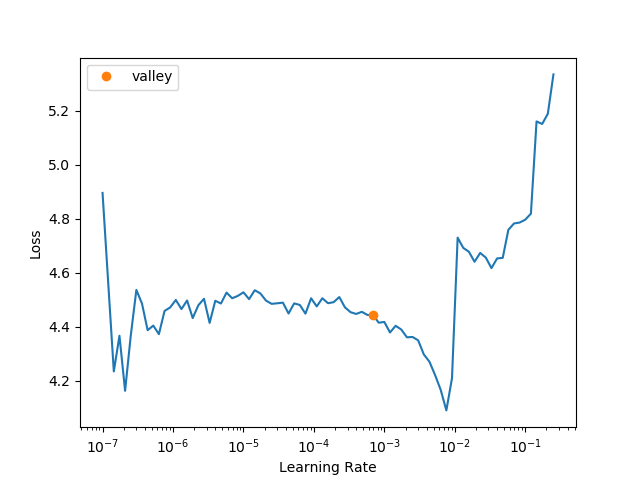

In [61]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(10, 0.006)

epoch,train_loss,valid_loss,_rmse,time
0,4.364668,6.052833,2.460251,00:00
1,4.356564,5.919309,2.432963,00:00
2,4.299425,4.884161,2.210014,00:00
3,4.331679,5.446634,2.333802,00:00
4,4.178292,5.374299,2.318253,00:00
5,4.047881,4.313810,2.076971,00:00
6,3.786224,3.261987,1.806097,00:00
7,3.512129,2.665633,1.632677,00:00
8,3.256114,2.451667,1.565780,00:00
9,3.040003,2.404298,1.550580,00:00


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
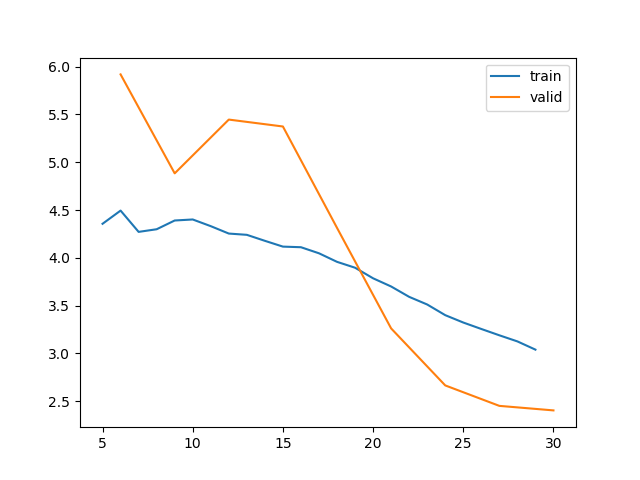

In [63]:
%matplotlib widget
learn.recorder.plot_loss()

In [64]:
x= torch.from_numpy(np.random.uniform(xmin,xmax,size=(1,2))).float()
print(f'x={x}')
with learn.no_bar(): print(f'  learn.predict(x)={learn.predict(x)[1]}')
net.eval()
with torch.no_grad(): print(f'  net(x)={net(x)}')
print()

x= dls.valid_ds[0]
print(f'x={x}')
with learn.no_bar(): print(f'  learn.predict(x)={learn.predict(x)[1]}')
# dls.valid_ds[0]
net.eval()
with torch.no_grad(): print(f'  net(x)={net(x[0])}')

x=tensor([[-3.5056,  3.4801]])
  learn.predict(x)=tensor([0.2997])
  net(x)=tensor([[0.2997]])

x=(tensor([-3.2659, -4.9619]), tensor([-2.3902]))
  learn.predict(x)=tensor([-1.2076])
  net(x)=tensor([-1.2076])


In [65]:
x= torch.from_numpy(np.random.uniform(xmin,xmax,size=(3,2))).float()
print(f'x={x}')
with learn.no_bar(): print(f'  learn.predict(x)={learn.predict((x,torch.zeros(x.shape[0])))[1]}')  #torch.zeros(...) is a dummy label (necessary)
net.eval()
with torch.no_grad(): print(f'  net(x)={net(x)}')
print()

x= dls.valid_ds[:3]
print(f'x={x}')
with learn.no_bar(): print(f'  learn.predict(x)={learn.predict(x)[1]}')
# dls.valid_ds[0]
net.eval()
with torch.no_grad(): print(f'  net(x)={net(x[0])}')

x=tensor([[-0.2597,  0.7350],
        [-3.5251, -3.5242],
        [ 2.8761, -1.8341]])
  learn.predict(x)=tensor([[-0.0960],
        [ 0.4739],
        [-2.0894]])
  net(x)=tensor([[-0.0960],
        [ 0.4739],
        [-2.0894]])

x=(tensor([[-3.2659, -4.9619],
        [-0.5300, -0.5858],
        [ 3.8223, -1.9377]]), tensor([[-2.3902],
        [ 1.1952],
        [-3.5685]]))
  learn.predict(x)=tensor([[-1.2076],
        [ 0.2651],
        [-3.0901]])
  net(x)=tensor([[-1.2076],
        [ 0.2651],
        [-3.0901]])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
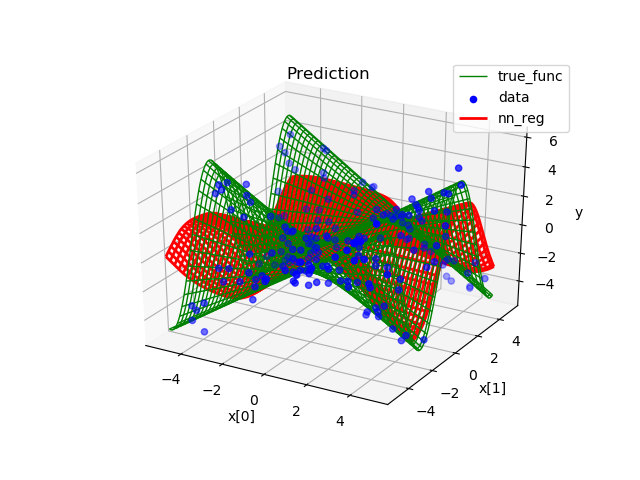

In [66]:
#Plot with net
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,projection='3d')

true_x= np.mgrid[xmin:xmax:0.1, xmin:xmax:0.1]
ax_pred.plot_wireframe(true_x[0], true_x[1], Func(true_x[:,:,:].reshape(2,-1).T).reshape(true_x.shape[1:]), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[:,0], data_x[:,1], data_y[:,0], color='blue', label='data')

net.eval()  # evaluation mode; disabling dropout.
true_x_var= torch.from_numpy(true_x[:,:,:].reshape(2,-1).T).float()
ax_pred.plot_wireframe(true_x[0], true_x[1], net(true_x_var).data.reshape(true_x.shape[1:]).cpu(), color='red', linewidth=2, label='nn_reg')

ax_pred.set_title('Prediction')
ax_pred.set_xlabel('x[0]')
ax_pred.set_ylabel('x[1]')
ax_pred.set_zlabel('y')
ax_pred.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
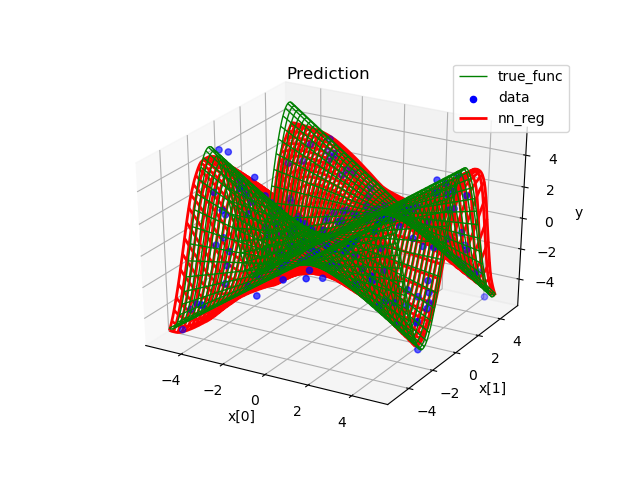

In [49]:
#Plot with learn
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,projection='3d')

true_x= np.mgrid[xmin:xmax:0.1, xmin:xmax:0.1]
ax_pred.plot_wireframe(true_x[0], true_x[1], Func(true_x[:,:,:].reshape(2,-1).T).reshape(true_x.shape[1:]), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[:,0], data_x[:,1], data_y[:,0], color='blue', label='data')

true_x_var= torch.from_numpy(true_x[:,:,:].reshape(2,-1).T).float()
ax_pred.plot_wireframe(true_x[0], true_x[1], learn.predict((true_x_var,torch.zeros(true_x_var.shape[0])))[1].reshape(true_x.shape[1:]), color='red', linewidth=2, label='nn_reg')

ax_pred.set_title('Prediction')
ax_pred.set_xlabel('x[0]')
ax_pred.set_ylabel('x[1]')
ax_pred.set_zlabel('y')
ax_pred.legend()